In [2]:
trafic_index = dict(pd.read_csv('data/processed/Full_data_set.csv', parse_dates = [8]).Reservation_Time.dt.hour.value_counts())

In [3]:
df = pd.read_csv('data/processed/Fall2019P.csv', index_col=0, parse_dates=[1])

df = df[df.next_customer]
df.drop(columns=['prev_customer', 'next_customer'], inplace = True)

df['weekend'] = df.time.dt.weekday//5
df['hour_index'] = df.time.dt.hour.map(trafic_index)

# Remove zones with too little support
df = df[~df.leave_zone.isin((df.leave_zone.value_counts() < 30).index[df.leave_zone.value_counts() < 30])]

df = pd.get_dummies(df, columns = ['engine','leave_zone'], prefix=['eng','lz'])

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 326794 entries, 0 to 340483
Columns: 279 entries, time to lz_185203
dtypes: bool(1), datetime64[ns](1), float64(7), int64(5), uint8(265)
memory usage: 117.8 MB


In [4]:
y = df.time_to_reservation

In [5]:
df.drop(columns=['time_to_reservation', 'time', 'park_location_lat', 'park_location_long', 'leave_location_lat', 'leave_location_long', 'leave_fuel', 'park_zone', 'moved', 'movedTF', 'degree'], inplace = True)
df

,park_fuel,weekend,hour_index,eng_118I,eng_COOPER,eng_I3,eng_X1,lz_102111,lz_102121,lz_102122,...,lz_185122,lz_185123,lz_185124,lz_185131,lz_185132,lz_185141,lz_185142,lz_185143,lz_185154,lz_185203
0,86,0,29779,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,84,0,29779,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,84,0,29779,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,50,0,29779,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,50,0,29779,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340479,59,0,49766,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
340480,50,0,49766,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
340481,31,0,49766,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
340482,58,0,49766,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data))

train_data = pd.concat([(train_data.filter(regex = '^(?!.*(lz|eng)).*$')-train_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/train_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), train_data.filter(regex = 'eng|lz')], axis = 1)
val_data = pd.concat([(val_data.filter(regex = '^(?!.*(lz|eng)).*$')-val_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/val_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), val_data.filter(regex = 'eng|lz')], axis = 1)
test_data = pd.concat([(test_data.filter(regex = '^(?!.*(lz|eng)).*$')-test_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/test_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), test_data.filter(regex = 'eng|lz')], axis = 1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

## Simple network

In [10]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(268,128),
            nn.ReLU(nn.BatchNorm1d(128)),
            nn.Dropout(0.4),
            nn.Linear(128,64),
            nn.ReLU(nn.BatchNorm1d(64)),
            nn.Dropout(0.4),
            nn.Linear(64,32),
            nn.ReLU(nn.BatchNorm1d(32)),
            nn.Dropout(0.4),
            nn.Linear(32,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x


net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=268, out_features=128, bias=True)
    (1): ReLU(
      inplace=True
      (inplace): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU(
      inplace=True
      (inplace): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (5): Dropout(p=0.4, inplace=False)
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU(
      inplace=True
      (inplace): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (8): Dropout(p=0.4, inplace=False)
    (9): Linear(in_features=32, out_features=1, bias=True)
  )
) 45249


In [11]:
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum = 0.9, weight_decay = 0.005) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1 : Train Loss 1.425449 , Train acc 0.034897, Valid acc 0.032493
Epoch 11 : Train Loss 1.291573 , Train acc 0.100660, Valid acc 0.094759
Epoch 21 : Train Loss 1.281579 , Train acc 0.114454, Valid acc 0.103509
Epoch 31 : Train Loss 1.271710 , Train acc 0.120340, Valid acc 0.108408
Epoch 41 : Train Loss 1.268041 , Train acc 0.129904, Valid acc 0.117027
Epoch 51 : Train Loss 1.266906 , Train acc 0.126256, Valid acc 0.112230
Epoch 61 : Train Loss 1.261720 , Train acc 0.123467, Valid acc 0.105909
Epoch 71 : Train Loss 1.258555 , Train acc 0.130110, Valid acc 0.112253
Epoch 81 : Train Loss 1.263190 , Train acc 0.125298, Valid acc 0.106574
Epoch 91 : Train Loss 1.258026 , Train acc 0.124421, Valid acc 0.105276
Epoch 101 : Train Loss 1.256917 , Train acc 0.129863, Valid acc 0.111068


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

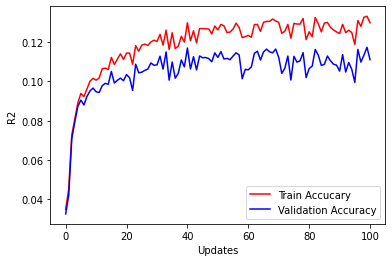

In [12]:
# setting hyperparameters and gettings epoch sizes
batch_size = 2048
num_epochs = 101
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())
        

    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

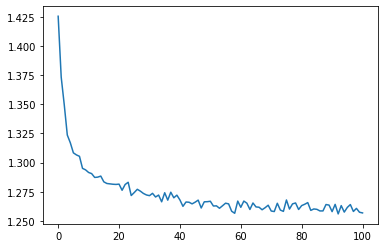

0.0961051495344043


In [13]:
plt.plot([x.detach() for x in losses])
plt.show()
print(r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]))

## With embedding

In [ ]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)

        self.embedding = nn.Embedding 

        self.seq = nn.Sequential(
            nn.Linear(263,128),
            nn.ReLU(nn.BatchNorm1d(128)),
            nn.Dropout(0.5),
            nn.Linear(128,64),
            nn.ReLU(nn.BatchNorm1d(64)),
            nn.Dropout(0.5),
            nn.Linear(64,32),
            nn.ReLU(nn.BatchNorm1d(32)),
            nn.Dropout(0.5),
            nn.Linear(32,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x


net = Net()
print(net, sum(p.numel() for p in net.parameters()))

In [333]:
X_train[:,7:].int()

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.int32)

In [329]:
emb = nn.Embedding(10,3, sparse = True)

In [ ]:
[-0.2680,  0.0216,  0.9065]-0.2680,  0.0216,  0.9065

In [344]:
X_train[2,7:].int().argmax()

tensor(146)

In [345]:
emb(X_train[:,7:].int())[2,:,:]

tensor([[-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
 

In [319]:
input = torch.LongTensor([[1,2,4,5],[4,3,2,9]])
emb(input)

tensor([[[-1.1585,  2.0188,  2.1123],
         [ 0.7063, -1.2334, -0.2562],
         [-1.9014,  0.3058,  0.3674],
         [ 0.5342, -1.6928, -0.4252]],

        [[-1.9014,  0.3058,  0.3674],
         [ 1.0778,  0.6448,  0.6322],
         [ 0.7063, -1.2334, -0.2562],
         [-1.2688, -0.6102,  0.4146]]], grad_fn=<EmbeddingBackward0>)

In [291]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data))

train_data = pd.concat([(train_data.filter(regex = '^(?!.*lz).*$')-train_data.filter(regex = '^(?!.*lz).*$').mean())/train_data.filter(regex = '^(?!.*lz).*$').std(ddof = 1), train_data.filter(regex = 'lz')], axis = 1)
val_data = pd.concat([(val_data.filter(regex = '^(?!.*lz).*$')-val_data.filter(regex = '^(?!.*lz).*$').mean())/val_data.filter(regex = '^(?!.*lz).*$').std(ddof = 1), val_data.filter(regex = 'lz')], axis = 1)
test_data = pd.concat([(test_data.filter(regex = '^(?!.*lz).*$')-test_data.filter(regex = '^(?!.*lz).*$').mean())/test_data.filter(regex = '^(?!.*lz).*$').std(ddof = 1), test_data.filter(regex = 'lz')], axis = 1)

In [292]:
X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [294]:
X_train

tensor([[-0.8179,  1.5905,  1.2673,  ...,  0.0000,  0.0000,  0.0000],
        [-0.9438, -0.6287, -0.3807,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.5665, -0.6287,  0.0636,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-1.8667, -0.6287, -2.1659,  ...,  0.0000,  0.0000,  0.0000],
        [ 1.3635, -0.6287,  1.2673,  ...,  0.0000,  0.0000,  0.0000],
        [-1.9926, -0.6287,  0.0636,  ...,  0.0000,  0.0000,  0.0000]])

## With degree

In [14]:
df = pd.read_csv('data/processed/OctNov.csv', index_col=0, parse_dates=[1])

df = df[df.next_customer]
df.drop(columns=['prev_customer', 'next_customer'], inplace = True)

df['weekend'] = df.time.dt.weekday//5
df['hour_index'] = df.time.dt.hour.map(trafic_index)

# Remove zones with too little support
df = df[~df.leave_zone.isin((df.leave_zone.value_counts() < 30).index[df.leave_zone.value_counts() < 30])]

df = pd.get_dummies(df, columns = ['engine','leave_zone'], prefix=['eng','lz'])


y = df.time_to_reservation
df.drop(columns=['time_to_reservation', 'time', 'park_location_lat', 'park_location_long', 'leave_location_lat', 'leave_location_long', 'leave_fuel', 'park_zone', 'moved', 'movedTF'], inplace = True)

In [15]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data))

train_data = pd.concat([(train_data.filter(regex = '^(?!.*(lz|eng)).*$')-train_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/train_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), train_data.filter(regex = 'eng|lz')], axis = 1)
val_data = pd.concat([(val_data.filter(regex = '^(?!.*(lz|eng)).*$')-val_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/val_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), val_data.filter(regex = 'eng|lz')], axis = 1)
test_data = pd.concat([(test_data.filter(regex = '^(?!.*(lz|eng)).*$')-test_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/test_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), test_data.filter(regex = 'eng|lz')], axis = 1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [16]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(264,64),
            nn.ReLU(nn.BatchNorm1d(64)),
            nn.Dropout(0.5),
            nn.Linear(64,64),
            nn.ReLU(nn.BatchNorm1d(64)),
            nn.Dropout(0.5),
            #nn.Linear(64,32),
            #nn.ReLU(nn.BatchNorm1d(32)),
            #nn.Dropout(0.5),
            nn.Linear(64,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x


net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=264, out_features=64, bias=True)
    (1): ReLU(
      inplace=True
      (inplace): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU(
      inplace=True
      (inplace): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
) 21441


In [17]:
optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay = 0.001) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1 : Train Loss 0.681823 , Train acc 0.117138, Valid acc 0.067940
Epoch 11 : Train Loss 0.590583 , Train acc 0.173820, Valid acc 0.091745
Epoch 21 : Train Loss 0.575491 , Train acc 0.190627, Valid acc 0.094669
Epoch 31 : Train Loss 0.579269 , Train acc 0.196527, Valid acc 0.096861
Epoch 41 : Train Loss 0.566590 , Train acc 0.205297, Valid acc 0.098074
Epoch 51 : Train Loss 0.570930 , Train acc 0.212425, Valid acc 0.089555
Epoch 61 : Train Loss 0.579659 , Train acc 0.219899, Valid acc 0.085352
Epoch 71 : Train Loss 0.545471 , Train acc 0.240274, Valid acc 0.073168
Epoch 81 : Train Loss 0.545419 , Train acc 0.249707, Valid acc 0.060504
Epoch 91 : Train Loss 0.520804 , Train acc 0.247776, Valid acc 0.069701
Epoch 101 : Train Loss 0.549683 , Train acc 0.252691, Valid acc 0.062768
Epoch 111 : Train Loss 0.517160 , Train acc 0.259610, Valid acc 0.074761
Epoch 121 : Train Loss 0.530948 , Train acc 0.246593, Valid acc 0.059237


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

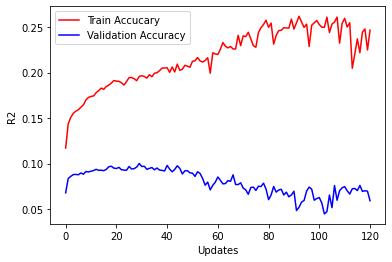

In [18]:
# setting hyperparameters and gettings epoch sizes
batch_size = 2048
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())
        

    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

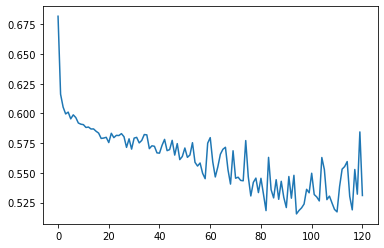

0.156624010506628


In [19]:
plt.plot([x.detach() for x in losses])
plt.show()
print(r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]))